In [1]:
import numpy as np
import matplotlib.pyplot as plt

import basic_ops, eigenvalues

In [2]:
def vec_norm(x):
    return max(abs(x))

def mat_norm(x):
    return max(
        abs((sum(abs(row))-abs(row[i])) \
        / 
        abs(row[i]))
        for i, row in enumerate(x)
    )

In [3]:
def gen_matrix(n,m,dd=None, symmetric=False):
    A = np.random.rand(n,m)
    if symmetric:
        A = (A+A.T)

    if dd is None:
        return A

    if n != m:
        raise RuntimeError(f'диагональное преобладание возможно только у квадратных матриц')

    # генерируем коэффициенты для диагонального преобладания
    dd_coefs = [dd * np.random.random() for _ in range(n)]
    dd_coefs[np.random.randint(0.3, n)] = 1 * dd
    for i in range(n):
        A[i,i] = (sum(abs(A[i])) - abs(A[i,i])) + dd_coefs[i]

    return A

In [4]:
def gen_slae(N):
    A = gen_matrix(N,N, dd=N/2, symmetric=True)
    print(A)
    x = np.random.rand(N)
    b = A@x
    return A, x, b

In [5]:
def one_param(A, f, tao, true_x, eps=0.0001, Aiv=None):
    N = len(A)

    # x = Px + g
    P = np.eye(N) - tao*A
    g = tao*f

    # проверим, что ||P|| < 1
    if Aiv is None:
        Aiv = eigenvalues.get_eigenvalues_and_eigenvectors(A)
    Piv = 1 - tao*np.array(Aiv)
    
    print(f'tao: {tao}, norm P: {max(abs(Piv))}', end=' ')

    try:
        assert max(abs(Piv))< 0.999
    except:
        print(f'iters: -1, norm P is too big')
        return None ,-1
    
    max_lambda = max(Piv)

    x_old = np.array([A[i,i] * f[i] for i in range(N)])
    # x_old = np.zeros(N)
    diff = np.ones(N)*9999
    iters_num = 0

    while vec_norm(diff) > eps:
        if iters_num > 1000:
            print(f'iters: {iters_num}, too many iters')   
            return None, -1

        x_new = P@x_old + g

        e1 =  np.linalg.norm(x_new - true_x)
        e2 = abs(max_lambda) * np.linalg.norm(x_old - true_x)
       
        # try:
        #     assert ((e2 - e1) >= 0) or (abs(e1-e2) < 0.0001)
        # except:
        #     print(f'iters: {iters_num}, bad covergence', e1, e2)
        #     return None, -1
        
        diff = x_old - x_new
        x_old=x_new
        iters_num+=1
    
    print(f'iters: {iters_num}')

    return x_new, iters_num

tao: 0.0, norm P: 1.0 iters: -1, norm P is too big
tao: 0.0006351743186915027, norm P: 0.9887135402113283 iters: 867
tao: 0.0012703486373830055, norm P: 0.9774270804226566 iters: 462
tao: 0.0019055229560745082, norm P: 0.9661406206339849 iters: 318
tao: 0.002540697274766011, norm P: 0.9548541608453132 iters: 244
tao: 0.0031758715934575134, norm P: 0.9435677010566415 iters: 198
tao: 0.0038110459121490164, norm P: 0.9322812412679697 iters: 167
tao: 0.004446220230840519, norm P: 0.920994781479298 iters: 144
tao: 0.005081394549532022, norm P: 0.9097083216906263 iters: 127
tao: 0.005716568868223524, norm P: 0.8984218619019545 iters: 114
tao: 0.006351743186915027, norm P: 0.8871354021132828 iters: 103
tao: 0.00698691750560653, norm P: 0.8758489423246111 iters: 94
tao: 0.007622091824298033, norm P: 0.8645624825359394 iters: 86
tao: 0.008257266142989536, norm P: 0.8532760227472677 iters: 80
tao: 0.008892440461681039, norm P: 0.841989562958596 iters: 74
tao: 0.009527614780372541, norm P: 0.8307

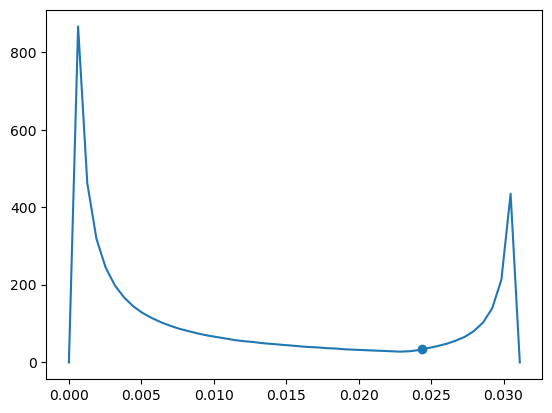

In [6]:
np.random.seed()

def analysis(N):
    # генерируем систему
    A = gen_matrix(N,N, dd=60, symmetric=True)
    x = np.random.rand(N)
    b = A@x

    # проверяем A
    assert mat_norm(A) < 1
    eigvals = eigenvalues.get_eigenvalues_and_eigenvectors(A, method=2)
    # eigvals = np.linalg.eigvals(A)
    assert all(map(lambda x: x>0, eigvals))

    # запускаем на разных тао
    taos = np.linspace(0, 2/max(eigvals), 50, True)
    res = [
        one_param(A, b, tao, true_x=x, Aiv=eigvals, eps=0.0001) 
        for tao in taos]
    
    # зависимость количества итераций от тао
    iters_num = list(map(lambda x: x[1], res))
    plt.plot(taos, iters_num)

    # нахдим оптимальное тао
    tao_opt = 2/(min(eigvals) + max(eigvals))
    iters_opt = one_param(A,b, tao_opt, x)[1]
    plt.scatter(tao_opt, iters_opt)

    print(f'tao optimal = {tao_opt}')
    print(f'iters optimal:', iters_opt)

    
analysis(5)